In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import math

In [208]:
initializer = tf.keras.initializers.glorot_normal()


encoder_input = tf.keras.Input(shape=(1))
#x = layers.Dense(24, activation="softplus", kernel_initializer=initializer)(encoder_input)
x = layers.Dense(16, activation="softplus",kernel_initializer=initializer)(x)
x = layers.Dense(16, activation="softplus",kernel_initializer=initializer)(x)
#x = layers.Dense(24, activation="softplus",kernel_initializer=initializer)(x)
#x = layers.Dense(16, activation="tanh",kernel_initializer=initializer)(x)
encoder_output = layers.Dense(1)(x)

In [204]:
reg = tf.keras.regularizers.l2(1)

tester_input = tf.keras.Input(shape=(1))
x = layers.Dense(12, activation="tanh", kernel_initializer=initializer,
                 kernel_regularizer=tf.keras.regularizers.l2(1))(tester_input)
x = layers.Dense(24, activation="tanh",kernel_initializer=initializer)(x)
#x = layers.Dense(35, activation="tanh",kernel_initializer=initializer)(x)
x = layers.Dense(12, activation="tanh",kernel_initializer=initializer,
                 kernel_regularizer=tf.keras.regularizers.l2(1))(x)
x = layers.Dense(12, activation="tanh",kernel_initializer=initializer,
                 kernel_regularizer=tf.keras.regularizers.l2(1))(x)
tester_output = layers.Dense(1)(x)



In [209]:
model = tf.keras.Model(encoder_input, encoder_output, name="encoder")
model.summary()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_30'), name='input_30', description="created by layer 'input_30'") at layer "dense_131". The following previous layers were accessed without issue: []

In [180]:
tester = tf.keras.Model(tester_input, tester_output,name='tester')
tester.summary()


Model: "tester"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_118 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_119 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_120 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 13        
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________


In [45]:
def pde_fluct(x,y):
    y_x = tf.gradients(y, x)[0]
    #y_xx = tf.gradients(y_x, x)[0]
    return tf.reduce_mean(y_x - y)

In [207]:
def bounday_fct(x):
    return np.sin(x*(np.pi))
N=100
#model.load_weights('checkpoints/lap_energy.h5')
#model = tf.keras.models.load_model('checkpoints/lap_variational_almost.h5')
x_len = np.linspace(0,1,N).reshape((N,1))
#x_len = tf.convert_to_tensor(x_len)
#model_loss = pde_fluct
x_tensor = tf.convert_to_tensor(x_len, dtype=tf.float32)



start = 1

for step in range(0,35000):

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
    with tf.GradientTape(persistent=True) as tape:

        # Create tensor that you will watch
        # f = -1
        tape.watch(x_tensor)
        # Feed forward
        output = model(x_tensor, training=True)*bounday_fct(x_tensor)
        test_fct = tester(x_tensor,training=True)/(tf.keras.backend.sum(tester(x_tensor))+0.001)
        y_x = tape.gradient(output,x_tensor)
        y_xx = tape.gradient(y_x,x_tensor)
        t_x = tape.gradient(test_fct,x_tensor)

        # Gradient and the corresponding loss function
        #o_x = tape.gradient(output, x_tensor)
        loss_direct = (tf.reduce_mean(input_tensor=(0.5*y_x**2 + output)**2)
                      #+ 100*tf.square(y_x[0]-1)
                      + 100*tf.square(output[0])
                      #+ 100*tf.square(output[0]-output[-1])
                      )

        loss_value = (tf.reduce_mean(input_tensor=(y_x*t_x + test_fct)**2)
                      #+ 100*tf.square(y_x[0]-1)
                      + 100*tf.square(output[0])
                      #+ 100*tf.square(output[0]-output[-1])
                      )
        #loss_value = tf.math.abs(loss_value)
        test_loss = -(tf.reduce_mean(input_tensor=(y_x*t_x + test_fct)**2))
            #tf.math.abs(tf.reduce_mean(input_tensor=(y_x*t_x + test_fct))               )
        #loss_value = model_loss(output, x_len)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00125)
    optimizer_t = tf.keras.optimizers.Adam(learning_rate=0.00035)
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    stepper = math.floor(step/10) % 2 ==0
    if True:
        #print('strasight train')
        mode ='direct'
        #print(loss_direct)
        grads_d = tape.gradient(loss_direct, model.trainable_weights)
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads_d, model.trainable_weights))
    else:
        mode = 'alt'
        step_l = step % 10 != 0
        if stepper:
        ## the same for tester

            grads_tester = tape.gradient(test_loss, tester.trainable_weights)
            optimizer_t.apply_gradients(zip(grads_tester, tester.trainable_weights))
        else:
            #print(loss_value)
            grads = tape.gradient(loss_value, model.trainable_weights)
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

    best_loss = 100
    # Log every 200 batches
    if step % 100 == 0:
        print(
            "Training loss in "+ mode + "  step:",
            step, float(loss_direct)
        )
        if best_loss < float(loss_value):
            model.save_weights('checkpoints/lap_energy_best.h5')
            best_loss = float(loss_value)

            #plt.plot(x_len, model(x_len))
            #plt.plot(x_len, np.exp(x_len))

Training loss in direct  step: 0 0.5350966453552246
Training loss in direct  step: 100 0.5349752902984619
Training loss in direct  step: 200 0.5348548889160156
Training loss in direct  step: 300 0.5347352027893066


KeyboardInterrupt: 

In [190]:
model.summary()
model.save('checkpoints/quad_variational.h5')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_113 (Dense)            (None, 24)                48        
_________________________________________________________________
dense_114 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_115 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_116 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 25        
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
_________________________________________________________

In [191]:
tester.summary()
tester.save('checkpoints/test_function_quad.h5')

Model: "tester"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_118 (Dense)            (None, 12)                24        
_________________________________________________________________
dense_119 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_120 (Dense)            (None, 12)                156       
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 13        
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________


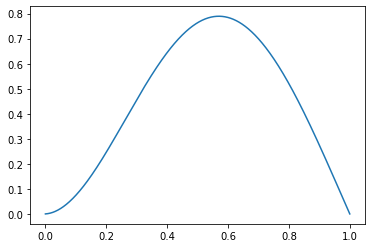

In [202]:
def sol(x):
    return (-x**2+x)
#print(model(x_len))
x_len = np.linspace(0,1,N).reshape((N,1))
plt.plot(x_len, model(x_len)*bounday_fct(x_len))
#plt.plot(x_len,tester(x_len))
#plt.plot(x_len, np.sin(x_len))

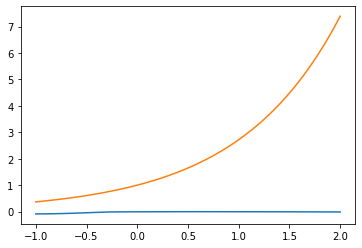

In [16]:
x_len = np.linspace(-1,2,1000).reshape((1000,1))
plt.plot(x_len, model(x_len))
plt.plot(x_len, np.exp(x_len))
